## 1. Import the dependencies

In [1]:
import os
import torch
import torch.nn as nn
import numpy as np
import cv2
import matplotlib.pyplot as plt
import itertools
import random
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import torch.nn.functional as F
import pandas as pd
import torch_fidelity


In [2]:
SEED = 42
print("Random Seed:", SEED)
random.seed(SEED)
np.random.seed(SEED)
torch_seed = torch.initial_seed()
torch.manual_seed(torch_seed)
print("Torch seed:" , torch_seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

cuda = torch.cuda.is_available()
Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

Random Seed: 42
Torch seed: 1812572933112200


## 2. Define your model

In [3]:
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        
        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // reduction_ratio, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // reduction_ratio, in_channels, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        out = self.conv(x_cat)
        return self.sigmoid(out)

class CBAM(nn.Module):
    def __init__(self, channels, reduction_ratio=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.channel_att = ChannelAttention(channels, reduction_ratio)
        self.spatial_att = SpatialAttention(kernel_size)
        
    def forward(self, x):
        x = x * self.channel_att(x)
        x = x * self.spatial_att(x)
        return x

class ImprovedResidualBlock(nn.Module):
    def __init__(self, in_features, use_cbam=True):
        super(ImprovedResidualBlock, self).__init__()
        
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, kernel_size=3, padding=0),
            nn.InstanceNorm2d(in_features),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, kernel_size=3, padding=0),
            nn.InstanceNorm2d(in_features)
        )
        
        # Add both SE and CBAM attention
        self.se = SqueezeExcitation(in_features)
        self.use_cbam = use_cbam
        if use_cbam:
            self.cbam = CBAM(in_features)
    
    def forward(self, x):
        out = self.block(x)
        out = self.se(out)  # Apply squeeze-excitation
        if self.use_cbam:
            out = self.cbam(out)  # Apply CBAM
        return x + out  # Skip connection

class SqueezeExcitation(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SqueezeExcitation, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super(SelfAttention, self).__init__()
        self.query_conv = nn.Conv2d(in_dim, in_dim//8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_dim, in_dim//8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_dim, in_dim, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))
        
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, x):
        batch_size, C, width, height = x.size()
        
        # Project to get query, key, value
        query = self.query_conv(x).view(batch_size, -1, width*height).permute(0, 2, 1)
        key = self.key_conv(x).view(batch_size, -1, width*height)
        value = self.value_conv(x).view(batch_size, -1, width*height)
        
        # Calculate attention map
        attention = torch.bmm(query, key)
        attention = self.softmax(attention)
        
        # Apply attention to value
        out = torch.bmm(value, attention.permute(0, 2, 1))
        out = out.view(batch_size, C, width, height)
        
        # Apply gamma parameter and add to input
        out = self.gamma * out + x
        return out

In [4]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features_d=64):
        super(Discriminator, self).__init__()
        
        self.scale_factor = 16
        
        # Feature extraction layers - shared between patch and global discriminators
        self.feature_extraction = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(in_channels, features_d, kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.utils.spectral_norm(nn.Conv2d(features_d, features_d*2, kernel_size=4, stride=2, padding=1)),
            nn.InstanceNorm2d(features_d*2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.utils.spectral_norm(nn.Conv2d(features_d*2, features_d*4, kernel_size=4, stride=2, padding=1)),
            nn.InstanceNorm2d(features_d*4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.utils.spectral_norm(nn.Conv2d(features_d*4, features_d*8, kernel_size=4, stride=2, padding=1)),
            nn.InstanceNorm2d(features_d*8),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        # PatchGAN output
        self.patch_output = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(features_d*8, 1, kernel_size=4, stride=1, padding=1))
        )
        
        # Global discriminator output
        self.global_output = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(features_d*8, 1)
        )
    
    def forward(self, x, get_features=False):
        features = self.feature_extraction(x)
        patch_out = self.patch_output(features)
        global_out = self.global_output(features)
        
        if get_features:
            # Return intermediate features for feature matching loss
            return patch_out, global_out, [features]
        return patch_out, global_out

In [5]:
class Generator(nn.Module):
    def __init__(self, in_channels=3, num_residual_blocks=9, use_attention=True):
        super(Generator, self).__init__()
        
        # Initial convolution block
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_channels, 64, kernel_size=7, padding=0),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        ]
        
        # Enhanced downsampling with more filters
        in_features = 64
        out_features = in_features * 2
        for _ in range(2):
            model += [
                nn.Conv2d(in_features, out_features, kernel_size=3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features * 2
        
        # Improved residual blocks with attention
        for i in range(num_residual_blocks):
            # Add CBAM to the middle blocks for global coherence
            use_cbam = (i >= 3 and i <= 6)
            model += [ImprovedResidualBlock(in_features, use_cbam=use_cbam)]
        
        # Add self-attention layer for better global coherence
        if use_attention:
            model += [SelfAttention(in_features)]
        
        # Enhanced upsampling pathway
        out_features = in_features // 2
        for _ in range(2):
            model += [
                nn.ConvTranspose2d(in_features, out_features, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features // 2
        
        # Output layer
        model += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, in_channels, kernel_size=7, padding=0),
            nn.Tanh()
        ]
        
        self.model = nn.Sequential(*model)
    
    def forward(self, x):
        return self.model(x)

In [6]:
def relativistic_loss(real_pred, fake_pred, criterion):
    # Standard GAN uses D(real) and D(fake) independently
    # Relativistic GAN compares real to fake samples
    
    # For patch-level predictions
    real_patch, real_global = real_pred
    fake_patch, fake_global = fake_pred
    
    # Relativistic average for patch outputs
    real_fake_diff_patch = real_patch - fake_patch.mean(0, keepdim=True)
    fake_real_diff_patch = fake_patch - real_patch.mean(0, keepdim=True)
    
    # Relativistic average for global outputs
    real_fake_diff_global = real_global - fake_global.mean(0, keepdim=True)
    fake_real_diff_global = fake_global - real_global.mean(0, keepdim=True)
    
    # Combine losses
    batch_size = real_global.size(0)
    ones = torch.ones(batch_size, 1).cuda() if torch.cuda.is_available() else torch.ones(batch_size, 1)
    zeros = torch.zeros(batch_size, 1).cuda() if torch.cuda.is_available() else torch.zeros(batch_size, 1)
    
    # Patch level loss
    loss_real_patch = criterion(real_fake_diff_patch, torch.ones_like(real_fake_diff_patch))
    loss_fake_patch = criterion(fake_real_diff_patch, torch.zeros_like(fake_real_diff_patch))
    
    # Global level loss
    loss_real_global = nn.BCEWithLogitsLoss()(real_fake_diff_global, ones)
    loss_fake_global = nn.BCEWithLogitsLoss()(fake_real_diff_global, zeros)
    
    # Combine patch and global losses
    loss_real = 0.7 * loss_real_patch + 0.3 * loss_real_global
    loss_fake = 0.7 * loss_fake_patch + 0.3 * loss_fake_global
    
    return (loss_real + loss_fake) / 2

def compute_gradient_penalty(discriminator, real_samples, fake_samples):
    # Random interpolation of real and fake samples
    alpha = torch.rand((real_samples.size(0), 1, 1, 1)).type(Tensor)
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    
    # Get discriminator output for interpolated images
    patch_interpolates, global_interpolates = discriminator(interpolates)
    
    # Set fake gradients for patch outputs
    fake_patch_grad = torch.ones_like(patch_interpolates).type(Tensor)
    patch_gradients = torch.autograd.grad(
        outputs=patch_interpolates,
        inputs=interpolates,
        grad_outputs=fake_patch_grad,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    
    # Flatten gradients and compute penalty
    patch_gradients = patch_gradients.reshape(real_samples.size(0), -1)
    patch_gradient_penalty = ((patch_gradients.norm(2, dim=1) - 1) ** 2).mean()
    
    # Set fake gradients for global outputs
    fake_global_grad = torch.ones_like(global_interpolates).type(Tensor)
    global_gradients = torch.autograd.grad(
        outputs=global_interpolates,
        inputs=interpolates,
        grad_outputs=fake_global_grad,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    
    # Flatten gradients and compute penalty
    global_gradients = global_gradients.reshape(real_samples.size(0), -1)
    global_gradient_penalty = ((global_gradients.norm(2, dim=1) - 1) ** 2).mean()
    
    # Combined penalty
    return 0.7 * patch_gradient_penalty + 0.3 * global_gradient_penalty

def feature_matching_loss(real_features, fake_features):
    """
    Calculate feature matching loss by comparing features extracted from real and fake images.
    
    Args:
        real_features: List of feature tensors from real images
        fake_features: List of feature tensors from fake images
        
    Returns:
        The mean absolute difference between real and fake features
    """
    # Initialize loss
    loss = 0.0
    
    # Both should be lists of the same length, containing feature maps
    assert len(real_features) == len(fake_features), "Feature lists must have same length"
    
    # Calculate L1 loss between corresponding feature maps
    for real_feat, fake_feat in zip(real_features, fake_features):
        # Make sure feature maps have same shape
        assert real_feat.shape == fake_feat.shape, f"Feature shapes don't match: {real_feat.shape} vs {fake_feat.shape}"
        # Calculate mean absolute error between feature maps
        loss += torch.mean(torch.abs(real_feat - fake_feat))
    
    # Average over number of feature maps
    return loss / len(real_features)

In [7]:
class ImagePool:
    def __init__(self, pool_size=50):
        """Initialize the ImagePool with a specified pool size."""
        self.pool_size = pool_size
        self.num_imgs = 0
        self.images = []

    def query(self, images):
        """
        Returns images from the pool.
        If the pool is not full, add the incoming images.
        Otherwise, randomly choose to return an old image or the current one.
        """
        if self.pool_size == 0:
            return images
        return_images = []
        for image in images:
            image = torch.unsqueeze(image.data, 0)  # add a batch dimension if needed
            if self.num_imgs < self.pool_size:
                self.images.append(image)
                self.num_imgs += 1
                return_images.append(image)
            else:
                # With probability 0.5, use a previously stored image
                if random.uniform(0, 1) > 0.5:
                    idx = random.randint(0, self.pool_size - 1)
                    tmp = self.images[idx].clone()
                    self.images[idx] = image
                    return_images.append(tmp)
                else:
                    return_images.append(image)
        return torch.cat(return_images, 0)

In [8]:
def print_epoch_losses(epoch, gen_losses, gen_AB_losses, gen_BA_losses, id_losses, gan_losses, cycle_losses, fm_losses, discA_losses, discB_losses):
    # Calculate average losses for the epoch
    avg_gen_loss = sum(gen_losses) / len(gen_losses)
    avg_gen_AB_loss = sum(gen_AB_losses) / len(gen_AB_losses)
    avg_gen_BA_loss = sum(gen_BA_losses) / len(gen_BA_losses)
    avg_id_loss = sum(id_losses) / len(id_losses)
    avg_gan_loss = sum(gan_losses) / len(gan_losses)
    avg_cycle_loss = sum(cycle_losses) / len(cycle_losses)
    avg_fm_loss = sum(fm_losses) / len(fm_losses)
    avg_discA_loss = sum(discA_losses) / len(discA_losses)
    avg_discB_loss = sum(discB_losses) / len(discB_losses)
    
    print(f"Epoch {epoch}:")
    print(f"  Generator Total Loss: {avg_gen_loss:.4f}")
    print(f"    G_AB (A->B) Loss:  {avg_gen_AB_loss:.4f}")
    print(f"    G_BA (B->A) Loss:  {avg_gen_BA_loss:.4f}")
    print(f"    Identity Loss:     {avg_id_loss:.4f}")
    print(f"    GAN Loss:          {avg_gan_loss:.4f}")
    print(f"    Cycle Loss:        {avg_cycle_loss:.4f}")
    print(f"    Feature Match:     {avg_fm_loss:.4f}")
    print(f"  Discriminator A Loss: {avg_discA_loss:.4f}")
    print(f"  Discriminator B Loss: {avg_discB_loss:.4f}")

def plot_losses(gen_loss_history, gen_AB_loss_history, gen_BA_loss_history, 
                id_loss_history, gan_loss_history, cycle_loss_history, fm_loss_history,
                discA_loss_history, discB_loss_history):
    epochs = range(1, len(gen_loss_history) + 1)
    
    plt.figure(figsize=(15, 10))
    
    # Plot Generator Losses
    plt.subplot(2, 2, 1)
    plt.plot(epochs, gen_loss_history, label="Total Generator Loss", color="blue")
    plt.plot(epochs, gen_AB_loss_history, label="G_AB Loss", color="cyan", linestyle="dashed")
    plt.plot(epochs, gen_BA_loss_history, label="G_BA Loss", color="magenta", linestyle="dashed")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Generator Total Losses")
    plt.legend()
    plt.grid()
    
    # Plot Component Losses
    plt.subplot(2, 2, 2)
    plt.plot(epochs, id_loss_history, label="Identity Loss", color="green")
    plt.plot(epochs, gan_loss_history, label="GAN Loss", color="red")
    plt.plot(epochs, cycle_loss_history, label="Cycle Loss", color="orange")
    plt.plot(epochs, fm_loss_history, label="Feature Match Loss", color="purple")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Components")
    plt.legend()
    plt.grid()
    
    # Plot Discriminator Losses
    plt.subplot(2, 2, 3)
    plt.plot(epochs, discA_loss_history, label="Discriminator A Loss", color="teal")
    plt.plot(epochs, discB_loss_history, label="Discriminator B Loss", color="brown")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Discriminator Losses")
    plt.legend()
    plt.grid()
    
    # Plot combined important losses for overall view
    plt.subplot(2, 2, 4)
    plt.plot(epochs, gen_loss_history, label="Generator Loss", color="blue")
    plt.plot(epochs, cycle_loss_history, label="Cycle Loss", color="orange")
    plt.plot(epochs, gan_loss_history, label="GAN Loss", color="red")
    plt.plot(epochs, [(a+b)/2 for a, b in zip(discA_loss_history, discB_loss_history)], 
             label="Avg Discriminator Loss", color="purple")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Key Losses")
    plt.legend()
    plt.grid()
    
    plt.tight_layout()
    plt.show()

def show_images(real_A, fake_B, recov_A, real_B, fake_A, recov_B, size=(256, 256), num_samples=5):
    """Display three rows of images: real A, fake B, reconstructed A, real B, fake A, reconstructed B"""
    # Denormalize images from [-1, 1] to [0, 1]
    def denorm(tensor):
        return (tensor * 0.5 + 0.5).clamp(0, 1)
    
    # Create a figure with 3 rows of images
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Only use a subset of images
    real_A = denorm(real_A[:num_samples])
    fake_B = denorm(fake_B[:num_samples])
    recov_A = denorm(recov_A[:num_samples])
    real_B = denorm(real_B[:num_samples])
    fake_A = denorm(fake_A[:num_samples])
    recov_B = denorm(recov_B[:num_samples])
    
    # Create grids from batches of images
    real_A_grid = make_grid(real_A, nrow=num_samples).permute(1, 2, 0).cpu().numpy()
    fake_B_grid = make_grid(fake_B, nrow=num_samples).permute(1, 2, 0).cpu().numpy()
    recov_A_grid = make_grid(recov_A, nrow=num_samples).permute(1, 2, 0).cpu().numpy()
    real_B_grid = make_grid(real_B, nrow=num_samples).permute(1, 2, 0).cpu().numpy()
    fake_A_grid = make_grid(fake_A, nrow=num_samples).permute(1, 2, 0).cpu().numpy()
    recov_B_grid = make_grid(recov_B, nrow=num_samples).permute(1, 2, 0).cpu().numpy()
    
    # Display the images
    axes[0, 0].imshow(real_A_grid)
    axes[0, 0].set_title("Real A (Domain A)")
    axes[0, 0].axis("off")
    
    axes[0, 1].imshow(fake_B_grid)
    axes[0, 1].set_title("Fake B (Generated from A)")
    axes[0, 1].axis("off")
    
    axes[0, 2].imshow(recov_A_grid)
    axes[0, 2].set_title("Reconstructed A")
    axes[0, 2].axis("off")
    
    axes[1, 0].imshow(real_B_grid)
    axes[1, 0].set_title("Real B (Domain B)")
    axes[1, 0].axis("off")
    
    axes[1, 1].imshow(fake_A_grid)
    axes[1, 1].set_title("Fake A (Generated from B)")
    axes[1, 1].axis("off")
    
    axes[1, 2].imshow(recov_B_grid)
    axes[1, 2].set_title("Reconstructed B")
    axes[1, 2].axis("off")
    
    plt.tight_layout()
    plt.show()

In [9]:
image_size = (256, 256)
batch_size = 2
n_epochs = 50
lr = 2e-4
betas = (0.5, 0.999)
lambda_cyc = 10.0
lambda_identity = 5.0
lambda_gan = 1.0
lambda_fm = 5.0
lambda_gp = 10.0
pool_size_A = 50
pool_size_B = 50
num_residual_blocks = 9
use_attention = True
features_d = 64
file_name = "EnhancedCycleGAN-256x256"

In [10]:

"""
Step 3. Define Loss
"""
criterion_GAN = nn.MSELoss()  # For adversarial loss
criterion_cycle = nn.L1Loss()  # For cycle consistency loss
criterion_identity = nn.L1Loss()  # For identity loss

"""
Step 4. Initalize G and D¶
"""
G_AB = Generator(in_channels=3, num_residual_blocks=num_residual_blocks, use_attention=True)
G_BA = Generator(in_channels=3, num_residual_blocks=num_residual_blocks, use_attention=True)
D_A = Discriminator(in_channels=3, features_d=features_d)
D_B = Discriminator(in_channels=3, features_d=features_d)

## Total parameters in CycleGAN should be less than 60MB
total_params = sum(p.numel() for p in G_AB.parameters()) + \
               sum(p.numel() for p in G_BA.parameters()) + \
               sum(p.numel() for p in D_A.parameters()) + \
               sum(p.numel() for p in D_B.parameters())


"""
# modification of parameters computation is forbidden
"""
total_params_million = total_params / (1024 * 1024)
print(f'Total parameters in CycleGAN model: {total_params_million:.2f} million')

cuda = torch.cuda.is_available()
print(f'cuda: {cuda}')
if cuda:
    G_AB = G_AB.cuda()
    D_B = D_B.cuda()
    G_BA = G_BA.cuda()
    D_A = D_A.cuda()

criterion_GAN = criterion_GAN.cuda()
criterion_cycle = criterion_cycle.cuda()
criterion_identity = criterion_identity.cuda()

"""
Step 5. Configure Optimizers
"""

# Optimizers
optimizer_G = torch.optim.Adam(itertools.chain(G_AB.parameters(), G_BA.parameters()), 
                               lr=lr, betas=betas)
optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=lr, betas=betas)
optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=lr, betas=betas)

# Learning rate schedulers
lr_scheduler_G = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer_G, T_0=10, T_mult=2, eta_min=1e-5
)
lr_scheduler_D_A = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer_D_A, T_0=10, T_mult=2, eta_min=1e-5
)
lr_scheduler_D_B = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer_D_B, T_0=10, T_mult=2, eta_min=1e-5
)

# Image pools
fake_A_pool = ImagePool(pool_size=pool_size_A)
fake_B_pool = ImagePool(pool_size=pool_size_B)

Total parameters in CycleGAN model: 27.34 million
cuda: True


In [11]:
# -------------------------
# Save Model
# -------------------------
def save_checkpoint(model, model_name, torch_seed, checkpoint_dir='checkpoints_best'):
    # Ensure the directory exists
    os.makedirs(checkpoint_dir, exist_ok=True)

    checkpoint = {
        'model': model.state_dict(),
        'torch_seed': torch_seed
    }

    filename = os.path.join(checkpoint_dir, f"{file_name}-{model_name}-best.pth")

    # Save the checkpoint
    torch.save(checkpoint, filename)
    print(f"Model saved to {filename}")

## 3. Load the data

In [12]:
"""
Step 6. DataLoader
"""
from zhirongImageDataset import ImageDataset
data_dir = './'
# data_dir = '/kaggle/input/group-project/image_image_translation'

image_size = (256, 256)
data_transforms = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainloader = DataLoader(
    ImageDataset(data_dir, mode='train', transforms=data_transforms),
    batch_size = batch_size,
    shuffle = True,
    num_workers = 4,
    pin_memory=True,
    persistent_workers=True,
)

validloader = DataLoader(
    ImageDataset(data_dir, mode='valid', transforms=data_transforms),
    batch_size = batch_size,
    shuffle = False,
)

In [13]:
# Initialize loss tracking lists
gen_loss_history = []
gen_AB_loss_history = []
gen_BA_loss_history = []
id_loss_history = []
gan_loss_history = []
cycle_loss_history = []
fm_loss_history = []
discA_loss_history = []
discB_loss_history = []

## 4. Train your **model**

Epoch 101/151: 100%|██████████| 1980/1980 [16:22<00:00,  2.02batch/s]


Epoch 101:
  Generator Total Loss: 5.6605
    G_AB (A->B) Loss:  3.1092
    G_BA (B->A) Loss:  2.5513
    Identity Loss:     0.0470
    GAN Loss:          1.3698
    Cycle Loss:        0.0661
    Feature Match:     0.1129
  Discriminator A Loss: 0.4305
  Discriminator B Loss: 0.3780


Epoch 102/151: 100%|██████████| 1980/1980 [15:52<00:00,  2.08batch/s]


Epoch 102:
  Generator Total Loss: 5.6974
    G_AB (A->B) Loss:  3.1253
    G_BA (B->A) Loss:  2.5721
    Identity Loss:     0.0473
    GAN Loss:          1.3913
    Cycle Loss:        0.0661
    Feature Match:     0.1120
  Discriminator A Loss: 0.4235
  Discriminator B Loss: 0.3742


Epoch 103/151: 100%|██████████| 1980/1980 [15:35<00:00,  2.12batch/s]


Epoch 103:
  Generator Total Loss: 5.5852
    G_AB (A->B) Loss:  3.0734
    G_BA (B->A) Loss:  2.5118
    Identity Loss:     0.0452
    GAN Loss:          1.3830
    Cycle Loss:        0.0628
    Feature Match:     0.1111
  Discriminator A Loss: 0.4264
  Discriminator B Loss: 0.3744


Epoch 104/151: 100%|██████████| 1980/1980 [15:37<00:00,  2.11batch/s]


Epoch 104:
  Generator Total Loss: 5.5313
    G_AB (A->B) Loss:  3.0444
    G_BA (B->A) Loss:  2.4869
    Identity Loss:     0.0431
    GAN Loss:          1.3900
    Cycle Loss:        0.0602
    Feature Match:     0.1117
  Discriminator A Loss: 0.4216
  Discriminator B Loss: 0.3720


Epoch 105/151: 100%|██████████| 1980/1980 [15:28<00:00,  2.13batch/s]


Epoch 105:
  Generator Total Loss: 5.4256
    G_AB (A->B) Loss:  2.9913
    G_BA (B->A) Loss:  2.4342
    Identity Loss:     0.0400
    GAN Loss:          1.3944
    Cycle Loss:        0.0559
    Feature Match:     0.1119
  Discriminator A Loss: 0.4192
  Discriminator B Loss: 0.3719


Epoch 106/151: 100%|██████████| 1980/1980 [15:28<00:00,  2.13batch/s]


Epoch 106:
  Generator Total Loss: 5.3323
    G_AB (A->B) Loss:  2.9450
    G_BA (B->A) Loss:  2.3873
    Identity Loss:     0.0370
    GAN Loss:          1.3981
    Cycle Loss:        0.0521
    Feature Match:     0.1126
  Discriminator A Loss: 0.4160
  Discriminator B Loss: 0.3706


Epoch 107/151: 100%|██████████| 1980/1980 [15:27<00:00,  2.14batch/s]


Epoch 107:
  Generator Total Loss: 5.2244
    G_AB (A->B) Loss:  2.8893
    G_BA (B->A) Loss:  2.3351
    Identity Loss:     0.0340
    GAN Loss:          1.4003
    Cycle Loss:        0.0479
    Feature Match:     0.1126
  Discriminator A Loss: 0.4121
  Discriminator B Loss: 0.3701


Epoch 108/151: 100%|██████████| 1980/1980 [15:29<00:00,  2.13batch/s]


Epoch 108:
  Generator Total Loss: 5.1382
    G_AB (A->B) Loss:  2.8470
    G_BA (B->A) Loss:  2.2912
    Identity Loss:     0.0314
    GAN Loss:          1.4026
    Cycle Loss:        0.0445
    Feature Match:     0.1129
  Discriminator A Loss: 0.4107
  Discriminator B Loss: 0.3685


Epoch 109/151: 100%|██████████| 1980/1980 [15:28<00:00,  2.13batch/s]


Epoch 109:
  Generator Total Loss: 5.0595
    G_AB (A->B) Loss:  2.8072
    G_BA (B->A) Loss:  2.2523
    Identity Loss:     0.0295
    GAN Loss:          1.4019
    Cycle Loss:        0.0416
    Feature Match:     0.1128
  Discriminator A Loss: 0.4079
  Discriminator B Loss: 0.3681


Epoch 110/151: 100%|██████████| 1980/1980 [15:29<00:00,  2.13batch/s]


Epoch 110:
  Generator Total Loss: 5.0066
    G_AB (A->B) Loss:  2.7813
    G_BA (B->A) Loss:  2.2253
    Identity Loss:     0.0284
    GAN Loss:          1.3997
    Cycle Loss:        0.0397
    Feature Match:     0.1129
  Discriminator A Loss: 0.4067
  Discriminator B Loss: 0.3675


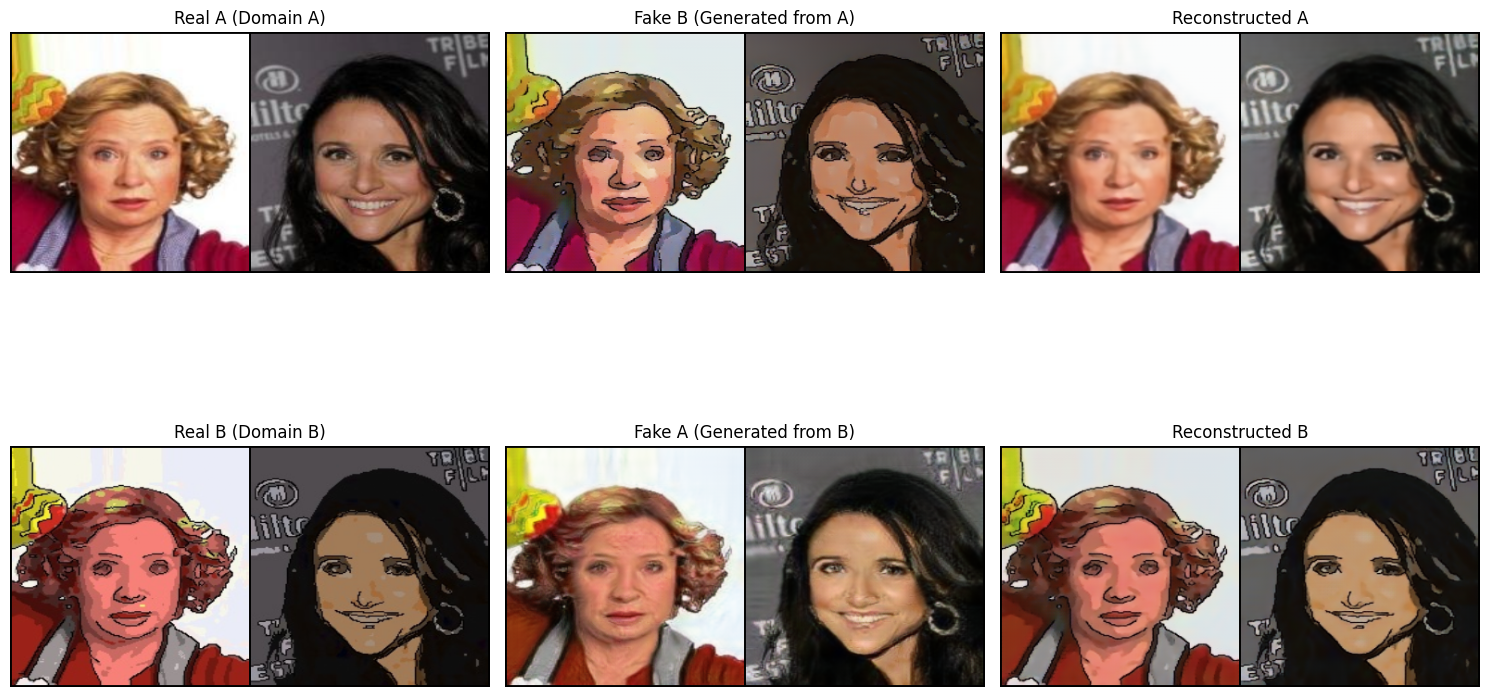

Epoch 111/151: 100%|██████████| 1980/1980 [15:31<00:00,  2.13batch/s]


Epoch 111:
  Generator Total Loss: 5.7300
    G_AB (A->B) Loss:  3.1259
    G_BA (B->A) Loss:  2.6040
    Identity Loss:     0.0495
    GAN Loss:          1.3612
    Cycle Loss:        0.0698
    Feature Match:     0.1117
  Discriminator A Loss: 0.4450
  Discriminator B Loss: 0.3909


Epoch 112/151: 100%|██████████| 1980/1980 [15:50<00:00,  2.08batch/s]


Epoch 112:
  Generator Total Loss: 5.6507
    G_AB (A->B) Loss:  3.0900
    G_BA (B->A) Loss:  2.5606
    Identity Loss:     0.0459
    GAN Loss:          1.3843
    Cycle Loss:        0.0645
    Feature Match:     0.1133
  Discriminator A Loss: 0.4214
  Discriminator B Loss: 0.3781


Epoch 113/151: 100%|██████████| 1980/1980 [15:56<00:00,  2.07batch/s]


Epoch 113:
  Generator Total Loss: 5.6041
    G_AB (A->B) Loss:  3.0742
    G_BA (B->A) Loss:  2.5299
    Identity Loss:     0.0445
    GAN Loss:          1.3895
    Cycle Loss:        0.0627
    Feature Match:     0.1127
  Discriminator A Loss: 0.4215
  Discriminator B Loss: 0.3775


Epoch 114/151: 100%|██████████| 1980/1980 [15:40<00:00,  2.11batch/s]


Epoch 114:
  Generator Total Loss: 5.5375
    G_AB (A->B) Loss:  3.0348
    G_BA (B->A) Loss:  2.5027
    Identity Loss:     0.0436
    GAN Loss:          1.3787
    Cycle Loss:        0.0609
    Feature Match:     0.1125
  Discriminator A Loss: 0.4220
  Discriminator B Loss: 0.3816


Epoch 115/151: 100%|██████████| 1980/1980 [15:28<00:00,  2.13batch/s]


Epoch 115:
  Generator Total Loss: 5.5700
    G_AB (A->B) Loss:  3.0718
    G_BA (B->A) Loss:  2.4982
    Identity Loss:     0.0428
    GAN Loss:          1.4043
    Cycle Loss:        0.0603
    Feature Match:     0.1128
  Discriminator A Loss: 0.4199
  Discriminator B Loss: 0.3705


Epoch 116/151: 100%|██████████| 1980/1980 [15:27<00:00,  2.13batch/s]


Epoch 116:
  Generator Total Loss: 5.4972
    G_AB (A->B) Loss:  3.0127
    G_BA (B->A) Loss:  2.4846
    Identity Loss:     0.0416
    GAN Loss:          1.3894
    Cycle Loss:        0.0585
    Feature Match:     0.1132
  Discriminator A Loss: 0.4183
  Discriminator B Loss: 0.3738


Epoch 117/151: 100%|██████████| 1980/1980 [15:26<00:00,  2.14batch/s]


Epoch 117:
  Generator Total Loss: 5.4549
    G_AB (A->B) Loss:  2.9987
    G_BA (B->A) Loss:  2.4562
    Identity Loss:     0.0399
    GAN Loss:          1.3963
    Cycle Loss:        0.0563
    Feature Match:     0.1137
  Discriminator A Loss: 0.4168
  Discriminator B Loss: 0.3717


Epoch 118/151: 100%|██████████| 1980/1980 [15:29<00:00,  2.13batch/s]


Epoch 118:
  Generator Total Loss: 5.4188
    G_AB (A->B) Loss:  2.9823
    G_BA (B->A) Loss:  2.4365
    Identity Loss:     0.0386
    GAN Loss:          1.3989
    Cycle Loss:        0.0548
    Feature Match:     0.1139
  Discriminator A Loss: 0.4145
  Discriminator B Loss: 0.3722


Epoch 119/151: 100%|██████████| 1980/1980 [15:27<00:00,  2.13batch/s]


Epoch 119:
  Generator Total Loss: 5.3767
    G_AB (A->B) Loss:  2.9584
    G_BA (B->A) Loss:  2.4183
    Identity Loss:     0.0371
    GAN Loss:          1.4048
    Cycle Loss:        0.0527
    Feature Match:     0.1141
  Discriminator A Loss: 0.4130
  Discriminator B Loss: 0.3711


Epoch 120/151: 100%|██████████| 1980/1980 [15:28<00:00,  2.13batch/s]


Epoch 120:
  Generator Total Loss: 5.3245
    G_AB (A->B) Loss:  2.9288
    G_BA (B->A) Loss:  2.3956
    Identity Loss:     0.0353
    GAN Loss:          1.4091
    Cycle Loss:        0.0505
    Feature Match:     0.1144
  Discriminator A Loss: 0.4108
  Discriminator B Loss: 0.3705


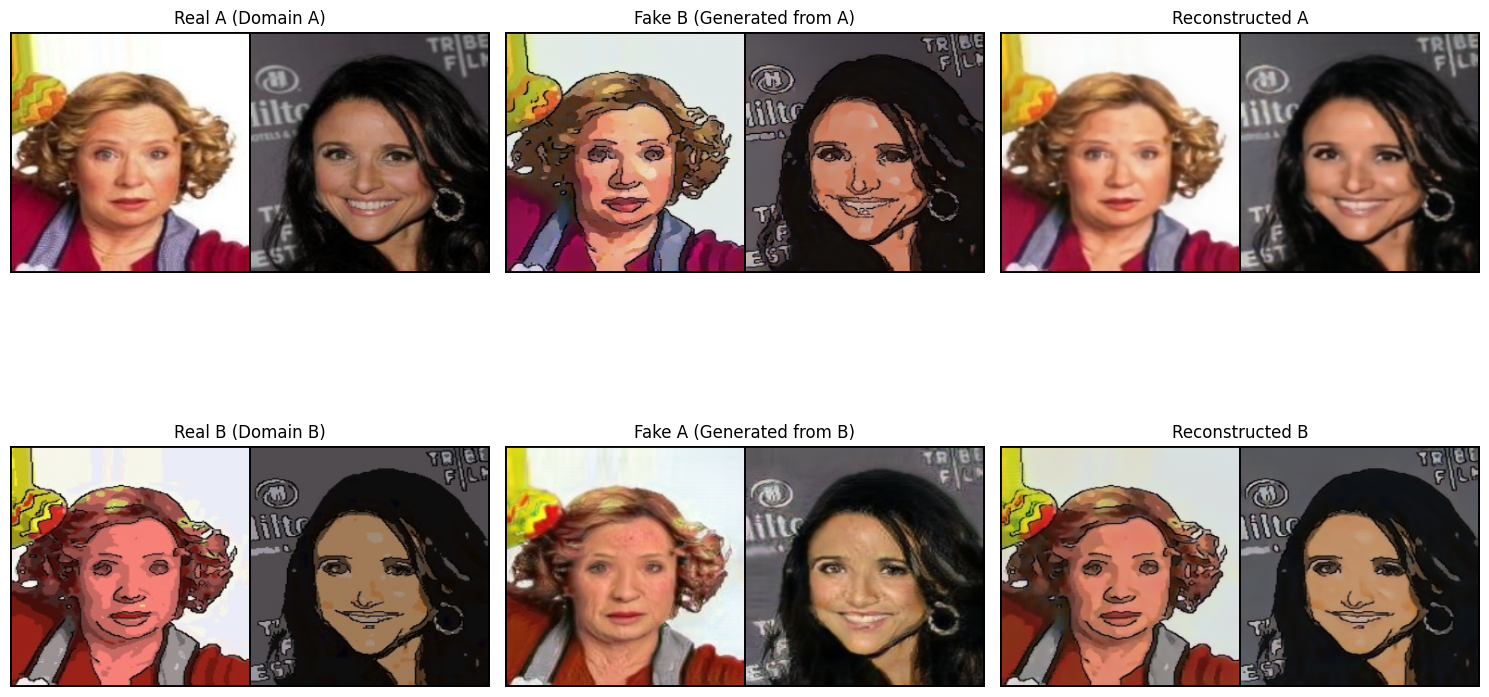

Epoch 121/151: 100%|██████████| 1980/1980 [15:28<00:00,  2.13batch/s]


Epoch 121:
  Generator Total Loss: 5.2722
    G_AB (A->B) Loss:  2.9046
    G_BA (B->A) Loss:  2.3676
    Identity Loss:     0.0337
    GAN Loss:          1.4092
    Cycle Loss:        0.0484
    Feature Match:     0.1150
  Discriminator A Loss: 0.4100
  Discriminator B Loss: 0.3697


Epoch 122/151: 100%|██████████| 1980/1980 [15:27<00:00,  2.13batch/s]


Epoch 122:
  Generator Total Loss: 5.2253
    G_AB (A->B) Loss:  2.8791
    G_BA (B->A) Loss:  2.3462
    Identity Loss:     0.0321
    GAN Loss:          1.4132
    Cycle Loss:        0.0463
    Feature Match:     0.1152
  Discriminator A Loss: 0.4074
  Discriminator B Loss: 0.3690


Epoch 123/151: 100%|██████████| 1980/1980 [15:27<00:00,  2.13batch/s]


Epoch 123:
  Generator Total Loss: 5.1775
    G_AB (A->B) Loss:  2.8520
    G_BA (B->A) Loss:  2.3255
    Identity Loss:     0.0306
    GAN Loss:          1.4136
    Cycle Loss:        0.0446
    Feature Match:     0.1153
  Discriminator A Loss: 0.4064
  Discriminator B Loss: 0.3690


Epoch 124/151: 100%|██████████| 1980/1980 [15:27<00:00,  2.13batch/s]


Epoch 124:
  Generator Total Loss: 5.1316
    G_AB (A->B) Loss:  2.8268
    G_BA (B->A) Loss:  2.3048
    Identity Loss:     0.0293
    GAN Loss:          1.4149
    Cycle Loss:        0.0426
    Feature Match:     0.1156
  Discriminator A Loss: 0.4052
  Discriminator B Loss: 0.3686


Epoch 125/151: 100%|██████████| 1980/1980 [15:29<00:00,  2.13batch/s]


Epoch 125:
  Generator Total Loss: 5.0847
    G_AB (A->B) Loss:  2.8030
    G_BA (B->A) Loss:  2.2817
    Identity Loss:     0.0281
    GAN Loss:          1.4138
    Cycle Loss:        0.0409
    Feature Match:     0.1158
  Discriminator A Loss: 0.4038
  Discriminator B Loss: 0.3685


Epoch 126/151: 100%|██████████| 1980/1980 [15:26<00:00,  2.14batch/s]


Epoch 126:
  Generator Total Loss: 5.0461
    G_AB (A->B) Loss:  2.7837
    G_BA (B->A) Loss:  2.2624
    Identity Loss:     0.0270
    GAN Loss:          1.4145
    Cycle Loss:        0.0394
    Feature Match:     0.1158
  Discriminator A Loss: 0.4025
  Discriminator B Loss: 0.3683


Epoch 127/151: 100%|██████████| 1980/1980 [15:28<00:00,  2.13batch/s]


Epoch 127:
  Generator Total Loss: 5.0037
    G_AB (A->B) Loss:  2.7611
    G_BA (B->A) Loss:  2.2426
    Identity Loss:     0.0262
    GAN Loss:          1.4102
    Cycle Loss:        0.0381
    Feature Match:     0.1159
  Discriminator A Loss: 0.4022
  Discriminator B Loss: 0.3682


Epoch 128/151: 100%|██████████| 1980/1980 [15:29<00:00,  2.13batch/s]


Epoch 128:
  Generator Total Loss: 4.9775
    G_AB (A->B) Loss:  2.7471
    G_BA (B->A) Loss:  2.2304
    Identity Loss:     0.0256
    GAN Loss:          1.4088
    Cycle Loss:        0.0372
    Feature Match:     0.1159
  Discriminator A Loss: 0.4012
  Discriminator B Loss: 0.3678


Epoch 129/151: 100%|██████████| 1980/1980 [15:28<00:00,  2.13batch/s]


Epoch 129:
  Generator Total Loss: 4.9515
    G_AB (A->B) Loss:  2.7315
    G_BA (B->A) Loss:  2.2200
    Identity Loss:     0.0252
    GAN Loss:          1.4046
    Cycle Loss:        0.0365
    Feature Match:     0.1160
  Discriminator A Loss: 0.4008
  Discriminator B Loss: 0.3680


Epoch 130/151: 100%|██████████| 1980/1980 [15:29<00:00,  2.13batch/s]


Epoch 130:
  Generator Total Loss: 4.9343
    G_AB (A->B) Loss:  2.7215
    G_BA (B->A) Loss:  2.2128
    Identity Loss:     0.0249
    GAN Loss:          1.4016
    Cycle Loss:        0.0361
    Feature Match:     0.1161
  Discriminator A Loss: 0.4006
  Discriminator B Loss: 0.3680


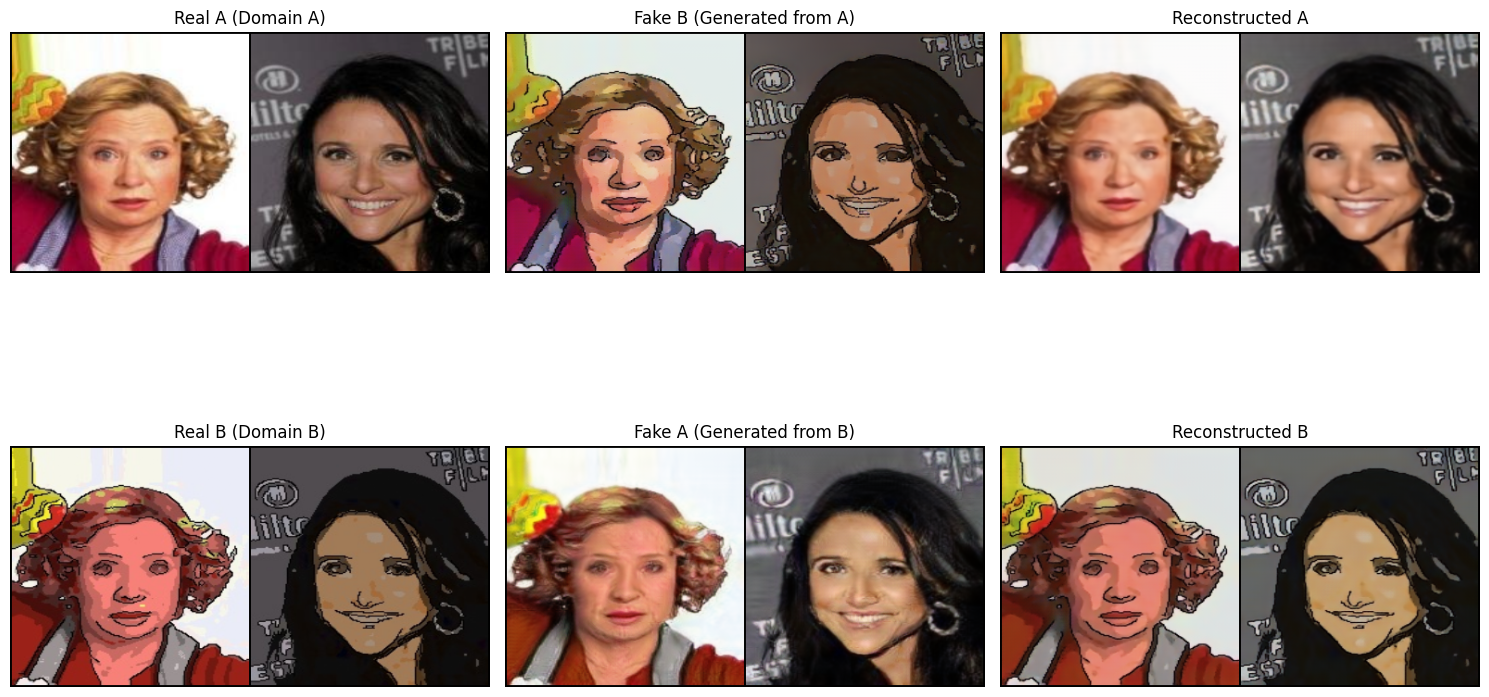

Epoch 131/151: 100%|██████████| 1980/1980 [15:28<00:00,  2.13batch/s]


Epoch 131:
  Generator Total Loss: 5.7611
    G_AB (A->B) Loss:  3.1358
    G_BA (B->A) Loss:  2.6253
    Identity Loss:     0.0464
    GAN Loss:          1.3886
    Cycle Loss:        0.0668
    Feature Match:     0.1184
  Discriminator A Loss: 0.4198
  Discriminator B Loss: 0.3913


Epoch 132/151: 100%|██████████| 1980/1980 [15:28<00:00,  2.13batch/s]


Epoch 132:
  Generator Total Loss: 5.6092
    G_AB (A->B) Loss:  3.0650
    G_BA (B->A) Loss:  2.5442
    Identity Loss:     0.0419
    GAN Loss:          1.4090
    Cycle Loss:        0.0601
    Feature Match:     0.1171
  Discriminator A Loss: 0.4154
  Discriminator B Loss: 0.3748


Epoch 133/151: 100%|██████████| 1980/1980 [15:28<00:00,  2.13batch/s]


Epoch 133:
  Generator Total Loss: 5.5587
    G_AB (A->B) Loss:  3.0312
    G_BA (B->A) Loss:  2.5275
    Identity Loss:     0.0412
    GAN Loss:          1.4021
    Cycle Loss:        0.0590
    Feature Match:     0.1163
  Discriminator A Loss: 0.4145
  Discriminator B Loss: 0.3790


Epoch 134/151: 100%|██████████| 1980/1980 [15:27<00:00,  2.13batch/s]


Epoch 134:
  Generator Total Loss: 5.5876
    G_AB (A->B) Loss:  3.0708
    G_BA (B->A) Loss:  2.5168
    Identity Loss:     0.0409
    GAN Loss:          1.4224
    Cycle Loss:        0.0586
    Feature Match:     0.1161
  Discriminator A Loss: 0.4155
  Discriminator B Loss: 0.3716


Epoch 135/151: 100%|██████████| 1980/1980 [15:28<00:00,  2.13batch/s]


Epoch 135:
  Generator Total Loss: 5.5623
    G_AB (A->B) Loss:  3.0427
    G_BA (B->A) Loss:  2.5196
    Identity Loss:     0.0406
    GAN Loss:          1.4152
    Cycle Loss:        0.0580
    Feature Match:     0.1166
  Discriminator A Loss: 0.4129
  Discriminator B Loss: 0.3747


Epoch 136/151: 100%|██████████| 1980/1980 [15:27<00:00,  2.13batch/s]


Epoch 136:
  Generator Total Loss: 5.6121
    G_AB (A->B) Loss:  3.0697
    G_BA (B->A) Loss:  2.5424
    Identity Loss:     0.0412
    GAN Loss:          1.4314
    Cycle Loss:        0.0586
    Feature Match:     0.1165
  Discriminator A Loss: 0.4121
  Discriminator B Loss: 0.3697


Epoch 137/151: 100%|██████████| 1980/1980 [15:26<00:00,  2.14batch/s]


Epoch 137:
  Generator Total Loss: 5.5440
    G_AB (A->B) Loss:  3.0453
    G_BA (B->A) Loss:  2.4988
    Identity Loss:     0.0396
    GAN Loss:          1.4292
    Cycle Loss:        0.0566
    Feature Match:     0.1158
  Discriminator A Loss: 0.4112
  Discriminator B Loss: 0.3714


Epoch 138/151: 100%|██████████| 1980/1980 [15:29<00:00,  2.13batch/s]


Epoch 138:
  Generator Total Loss: 5.5296
    G_AB (A->B) Loss:  3.0310
    G_BA (B->A) Loss:  2.4985
    Identity Loss:     0.0390
    GAN Loss:          1.4282
    Cycle Loss:        0.0559
    Feature Match:     0.1165
  Discriminator A Loss: 0.4094
  Discriminator B Loss: 0.3702


Epoch 139/151: 100%|██████████| 1980/1980 [15:26<00:00,  2.14batch/s]


Epoch 139:
  Generator Total Loss: 5.5154
    G_AB (A->B) Loss:  3.0069
    G_BA (B->A) Loss:  2.5085
    Identity Loss:     0.0384
    GAN Loss:          1.4313
    Cycle Loss:        0.0553
    Feature Match:     0.1162
  Discriminator A Loss: 0.4064
  Discriminator B Loss: 0.3722


Epoch 140/151: 100%|██████████| 1980/1980 [15:27<00:00,  2.13batch/s]


Epoch 140:
  Generator Total Loss: 5.4939
    G_AB (A->B) Loss:  3.0200
    G_BA (B->A) Loss:  2.4739
    Identity Loss:     0.0375
    GAN Loss:          1.4351
    Cycle Loss:        0.0541
    Feature Match:     0.1166
  Discriminator A Loss: 0.4098
  Discriminator B Loss: 0.3682


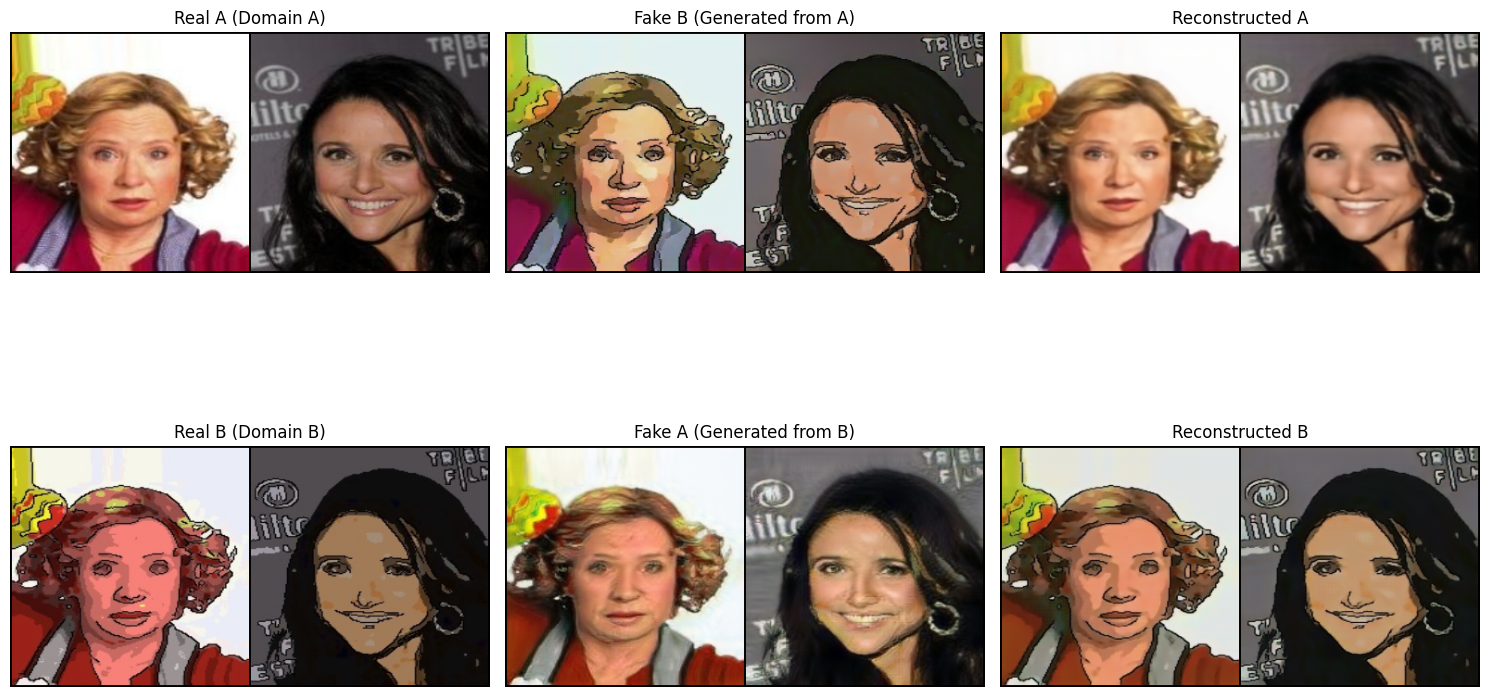

Epoch 141/151: 100%|██████████| 1980/1980 [15:27<00:00,  2.14batch/s]


Epoch 141:
  Generator Total Loss: 5.5016
    G_AB (A->B) Loss:  3.0115
    G_BA (B->A) Loss:  2.4901
    Identity Loss:     0.0372
    GAN Loss:          1.4390
    Cycle Loss:        0.0539
    Feature Match:     0.1173
  Discriminator A Loss: 0.4068
  Discriminator B Loss: 0.3695


Epoch 142/151: 100%|██████████| 1980/1980 [15:26<00:00,  2.14batch/s]


Epoch 142:
  Generator Total Loss: 5.4643
    G_AB (A->B) Loss:  2.9899
    G_BA (B->A) Loss:  2.4744
    Identity Loss:     0.0364
    GAN Loss:          1.4367
    Cycle Loss:        0.0527
    Feature Match:     0.1174
  Discriminator A Loss: 0.4065
  Discriminator B Loss: 0.3700


Epoch 143/151: 100%|██████████| 1980/1980 [15:29<00:00,  2.13batch/s]


Epoch 143:
  Generator Total Loss: 5.4458
    G_AB (A->B) Loss:  2.9782
    G_BA (B->A) Loss:  2.4676
    Identity Loss:     0.0357
    GAN Loss:          1.4388
    Cycle Loss:        0.0518
    Feature Match:     0.1175
  Discriminator A Loss: 0.4029
  Discriminator B Loss: 0.3702


Epoch 144/151: 100%|██████████| 1980/1980 [15:54<00:00,  2.07batch/s]


Epoch 144:
  Generator Total Loss: 5.4290
    G_AB (A->B) Loss:  2.9755
    G_BA (B->A) Loss:  2.4535
    Identity Loss:     0.0347
    GAN Loss:          1.4464
    Cycle Loss:        0.0507
    Feature Match:     0.1175
  Discriminator A Loss: 0.4043
  Discriminator B Loss: 0.3672


Epoch 145/151: 100%|██████████| 1980/1980 [15:51<00:00,  2.08batch/s]


Epoch 145:
  Generator Total Loss: 5.3943
    G_AB (A->B) Loss:  2.9548
    G_BA (B->A) Loss:  2.4395
    Identity Loss:     0.0341
    GAN Loss:          1.4416
    Cycle Loss:        0.0496
    Feature Match:     0.1178
  Discriminator A Loss: 0.4034
  Discriminator B Loss: 0.3685


Epoch 146/151: 100%|██████████| 1980/1980 [15:43<00:00,  2.10batch/s]


Epoch 146:
  Generator Total Loss: 5.3821
    G_AB (A->B) Loss:  2.9460
    G_BA (B->A) Loss:  2.4361
    Identity Loss:     0.0333
    GAN Loss:          1.4468
    Cycle Loss:        0.0488
    Feature Match:     0.1180
  Discriminator A Loss: 0.4013
  Discriminator B Loss: 0.3686


Epoch 147/151: 100%|██████████| 1980/1980 [15:25<00:00,  2.14batch/s]


Epoch 147:
  Generator Total Loss: 5.3654
    G_AB (A->B) Loss:  2.9391
    G_BA (B->A) Loss:  2.4262
    Identity Loss:     0.0324
    GAN Loss:          1.4535
    Cycle Loss:        0.0476
    Feature Match:     0.1182
  Discriminator A Loss: 0.4010
  Discriminator B Loss: 0.3665


Epoch 148/151: 100%|██████████| 1980/1980 [15:28<00:00,  2.13batch/s]


Epoch 148:
  Generator Total Loss: 5.3424
    G_AB (A->B) Loss:  2.9158
    G_BA (B->A) Loss:  2.4266
    Identity Loss:     0.0318
    GAN Loss:          1.4504
    Cycle Loss:        0.0469
    Feature Match:     0.1185
  Discriminator A Loss: 0.3996
  Discriminator B Loss: 0.3672


Epoch 149/151: 100%|██████████| 1980/1980 [15:28<00:00,  2.13batch/s]


Epoch 149:
  Generator Total Loss: 5.3067
    G_AB (A->B) Loss:  2.8998
    G_BA (B->A) Loss:  2.4069
    Identity Loss:     0.0309
    GAN Loss:          1.4492
    Cycle Loss:        0.0457
    Feature Match:     0.1186
  Discriminator A Loss: 0.3999
  Discriminator B Loss: 0.3684


Epoch 150/151: 100%|██████████| 1980/1980 [15:28<00:00,  2.13batch/s]


Epoch 150:
  Generator Total Loss: 5.3063
    G_AB (A->B) Loss:  2.9030
    G_BA (B->A) Loss:  2.4033
    Identity Loss:     0.0301
    GAN Loss:          1.4611
    Cycle Loss:        0.0448
    Feature Match:     0.1187
  Discriminator A Loss: 0.3982
  Discriminator B Loss: 0.3654


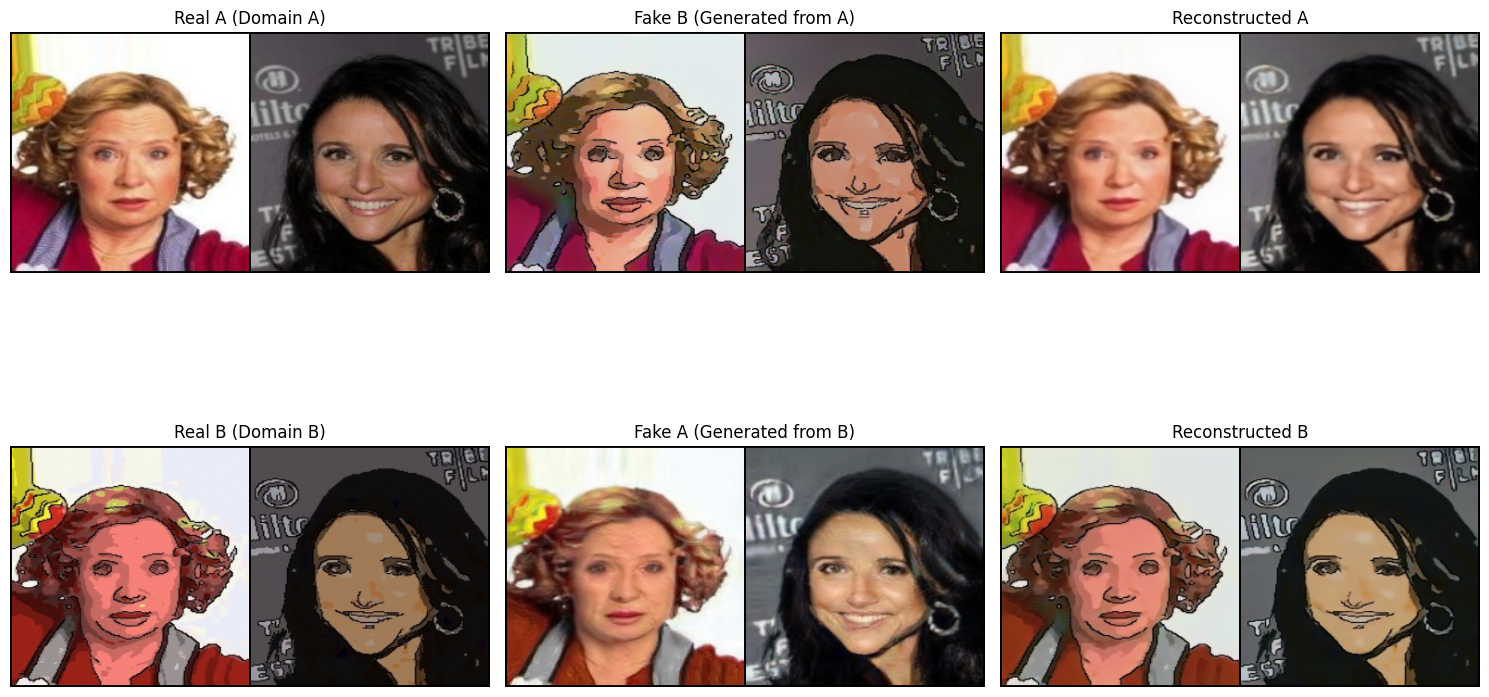

In [14]:
from tqdm import tqdm

# Initialise weights from before
G_AB.load_state_dict(torch.load('checkpoints/G_AB_99.pth'))
G_BA.load_state_dict(torch.load('checkpoints/G_BA_99.pth'))
D_A.load_state_dict(torch.load('checkpoints/D_A_99.pth'))
D_B.load_state_dict(torch.load('checkpoints/D_B_99.pth'))

# Training loop
for epoch in range(101, 101 + n_epochs):
    # Initialize epoch loss tracking
    epoch_gen_losses = []
    epoch_gen_AB_losses = []
    epoch_gen_BA_losses = []
    epoch_id_losses = []
    epoch_gan_losses = []
    epoch_cycle_losses = []
    epoch_fm_losses = []
    epoch_discA_losses = []
    epoch_discB_losses = []
    
    # Iterate through batches
    for real_A, real_B in tqdm(trainloader, unit="batch", desc=f"Epoch {epoch}/{n_epochs+101}"):
        real_A, real_B = real_A.type(Tensor).to(), real_B.type(Tensor)
        batch_size = real_A.size(0)
        
        # Set models to training mode
        G_AB.train()
        G_BA.train()
        D_A.train()
        D_B.train()
        
        # Ground truth labels
        valid = torch.ones((batch_size, 1, real_A.size(2) // D_A.scale_factor, 
                          real_A.size(3) // D_A.scale_factor)).type(Tensor)
        fake = torch.zeros((batch_size, 1, real_A.size(2) // D_A.scale_factor, 
                          real_A.size(3) // D_A.scale_factor)).type(Tensor)
        
        # Binary labels for global discriminator
        valid_global = torch.ones(batch_size, 1).type(Tensor)
        fake_global = torch.zeros(batch_size, 1).type(Tensor)
        
        #------------------
        # Train Generators
        #------------------
        optimizer_G.zero_grad()
        
        # Generate fake images
        fake_B = G_AB(real_A)
        fake_A = G_BA(real_B)
        
        # Identity loss
        loss_id_A = criterion_identity(G_BA(real_A), real_A)
        loss_id_B = criterion_identity(G_AB(real_B), real_B)
        loss_identity = (loss_id_A + loss_id_B) / 2
        
        # GAN loss with feature extraction for feature matching
        patch_real_A, global_real_A, features_real_A = D_A(real_A, get_features=True)
        patch_fake_A, global_fake_A, features_fake_A = D_A(fake_A, get_features=True)
        patch_real_B, global_real_B, features_real_B = D_B(real_B, get_features=True)
        patch_fake_B, global_fake_B, features_fake_B = D_B(fake_B, get_features=True)
        
        # Relativistic average GAN loss for generators
        loss_GAN_AB = 0.7 * F.mse_loss(patch_fake_B - patch_real_B.mean(0, keepdim=True), 
                                      torch.ones_like(patch_fake_B)) + \
                      0.3 * F.binary_cross_entropy_with_logits(
                          global_fake_B - global_real_B.mean(0, keepdim=True), valid_global)
        
        loss_GAN_BA = 0.7 * F.mse_loss(patch_fake_A - patch_real_A.mean(0, keepdim=True), 
                                      torch.ones_like(patch_fake_A)) + \
                      0.3 * F.binary_cross_entropy_with_logits(
                          global_fake_A - global_real_A.mean(0, keepdim=True), valid_global)
        
        loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2
        
        # Feature matching loss
        loss_FM_A = feature_matching_loss(features_real_A, features_fake_A)
        loss_FM_B = feature_matching_loss(features_real_B, features_fake_B)
        loss_FM = (loss_FM_A + loss_FM_B) / 2 
        
        # Cycle consistency loss
        recov_A = G_BA(fake_B)
        recov_B = G_AB(fake_A)
        loss_cycle_A = criterion_cycle(recov_A, real_A)
        loss_cycle_B = criterion_cycle(recov_B, real_B)
        loss_cycle = (loss_cycle_A + loss_cycle_B) / 2
        
        # Total generator loss with adaptive weights
        loss_G_AB = lambda_identity * loss_id_A + lambda_gan * loss_GAN_AB + \
                    lambda_cyc * loss_cycle_A + lambda_fm * loss_FM_A
        
        loss_G_BA = lambda_identity * loss_id_B + lambda_gan * loss_GAN_BA + \
                    lambda_cyc * loss_cycle_B + lambda_fm * loss_FM_B
        
        loss_G = loss_G_AB + loss_G_BA
        
        # Backward pass and optimize
        loss_G.backward()
        optimizer_G.step()
        
        #------------------
        # Train Discriminator A
        #------------------
        optimizer_D_A.zero_grad()
        
        # Get real and fake samples (using pool for fake samples)
        fake_A_ = fake_A_pool.query(fake_A.detach())
        
        # Get discriminator outputs
        real_patch_A, real_global_A = D_A(real_A)
        fake_patch_A, fake_global_A = D_A(fake_A_.detach())
        
        # Relativistic loss for discriminator A
        loss_D_A_rel = relativistic_loss(
            (real_patch_A, real_global_A),
            (fake_patch_A, fake_global_A),
            F.mse_loss
        )
        
        # Gradient penalty
        loss_D_A_gp = compute_gradient_penalty(D_A, real_A, fake_A_.detach())
        
        # Total discriminator loss
        loss_D_A = loss_D_A_rel + lambda_gp * loss_D_A_gp
        
        # Backward pass and optimize
        loss_D_A.backward()
        optimizer_D_A.step()
        
        #------------------
        # Train Discriminator B
        #------------------
        optimizer_D_B.zero_grad()
        
        # Get real and fake samples (using pool for fake samples)
        fake_B_ = fake_B_pool.query(fake_B.detach())
        
        # Get discriminator outputs
        real_patch_B, real_global_B = D_B(real_B)
        fake_patch_B, fake_global_B = D_B(fake_B_.detach())
        
        # Relativistic loss for discriminator B
        loss_D_B_rel = relativistic_loss(
            (real_patch_B, real_global_B),
            (fake_patch_B, fake_global_B),
            F.mse_loss
        )
        
        # Gradient penalty
        loss_D_B_gp = compute_gradient_penalty(D_B, real_B, fake_B_.detach())
        
        # Total discriminator loss
        loss_D_B = loss_D_B_rel + lambda_gp * loss_D_B_gp
        
        # Backward pass and optimize
        loss_D_B.backward()
        optimizer_D_B.step()
        
        # Record losses for this batch
        epoch_gen_losses.append(loss_G.item())
        epoch_gen_AB_losses.append(loss_G_AB.item())
        epoch_gen_BA_losses.append(loss_G_BA.item())
        epoch_id_losses.append(loss_identity.item())
        epoch_gan_losses.append(loss_GAN.item())
        epoch_cycle_losses.append(loss_cycle.item())
        epoch_fm_losses.append(loss_FM.item())
        epoch_discA_losses.append(loss_D_A.item())
        epoch_discB_losses.append(loss_D_B.item())
    
    # Update learning rates
    lr_scheduler_G.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()
    
    # Print epoch statistics
    print_epoch_losses(epoch, epoch_gen_losses, epoch_gen_AB_losses, epoch_gen_BA_losses,
                      epoch_id_losses, epoch_gan_losses, epoch_cycle_losses, epoch_fm_losses,
                      epoch_discA_losses, epoch_discB_losses)
    
    # Record the epoch averages in history
    gen_loss_history.append(sum(epoch_gen_losses) / len(epoch_gen_losses))
    gen_AB_loss_history.append(sum(epoch_gen_AB_losses) / len(epoch_gen_AB_losses))
    gen_BA_loss_history.append(sum(epoch_gen_BA_losses) / len(epoch_gen_BA_losses))
    id_loss_history.append(sum(epoch_id_losses) / len(epoch_id_losses))
    gan_loss_history.append(sum(epoch_gan_losses) / len(epoch_gan_losses))
    cycle_loss_history.append(sum(epoch_cycle_losses) / len(epoch_cycle_losses))
    fm_loss_history.append(sum(epoch_fm_losses) / len(epoch_fm_losses))
    discA_loss_history.append(sum(epoch_discA_losses) / len(epoch_discA_losses))
    discB_loss_history.append(sum(epoch_discB_losses) / len(epoch_discB_losses))
    
    # Validation and visualization every 10 epochs
    if epoch % 10 == 0:
        # Set models to evaluation mode
        G_AB.eval()
        G_BA.eval()
        
        # Get validation samples
        valid_iter = iter(validloader)
        valid_real_A, valid_real_B = next(valid_iter)
        valid_real_A, valid_real_B = valid_real_A.type(Tensor), valid_real_B.type(Tensor)
        
        # Generate validation results
        with torch.no_grad():
            # Generate fake samples
            valid_fake_B = G_AB(valid_real_A)
            valid_fake_A = G_BA(valid_real_B)
            
            # Generate reconstructed samples
            valid_recov_A = G_BA(valid_fake_B)
            valid_recov_B = G_AB(valid_fake_A)
        
        # Visualize validation results
        show_images(valid_real_A, valid_fake_B, valid_recov_A,
                   valid_real_B, valid_fake_A, valid_recov_B)
        
        torch.save(G_AB.state_dict(), f'checkpoints/G_AB_{epoch}.pth')
        torch.save(D_A.state_dict(), f'checkpoints/D_A_{epoch}.pth')
        torch.save(G_BA.state_dict(), f'checkpoints/G_BA_{epoch}.pth')
        torch.save(D_B.state_dict(), f'checkpoints/D_B_{epoch}.pth')


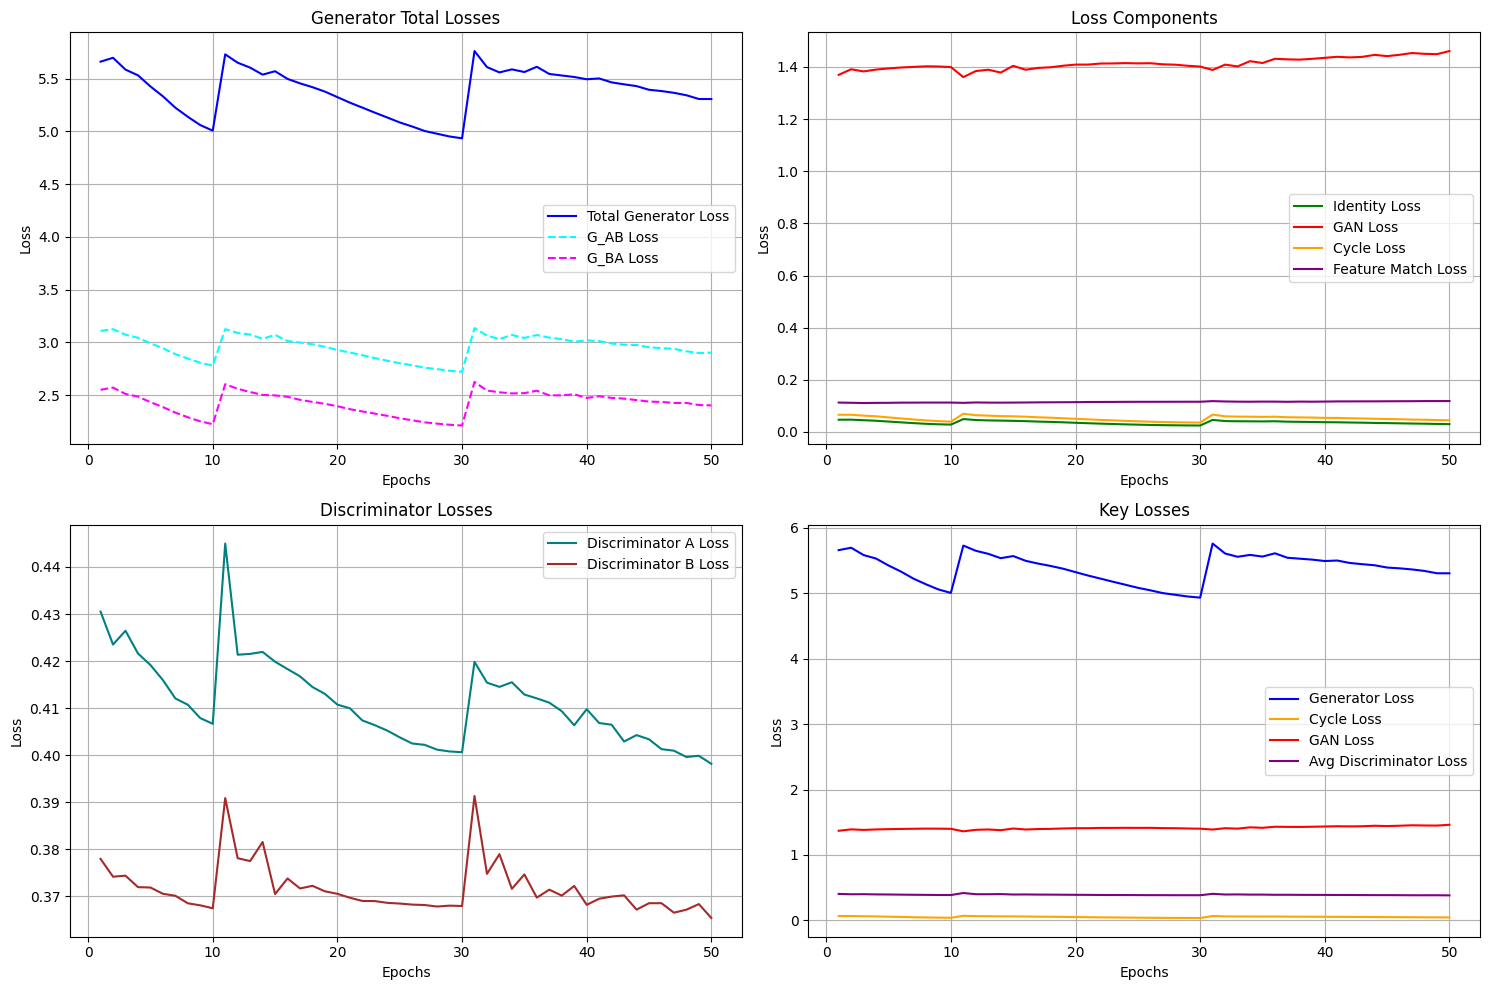

In [15]:
plot_losses(gen_loss_history, gen_AB_loss_history, gen_BA_loss_history,
           id_loss_history, gan_loss_history, cycle_loss_history, fm_loss_history,
           discA_loss_history, discB_loss_history)

In [16]:
%%script echo skipping --no-raise-error
save_checkpoint(G_AB, "G_AB", torch_seed)
save_checkpoint(G_BA, "G_BA", torch_seed)
save_checkpoint(D_A, "D_A", torch_seed)
save_checkpoint(D_B, "D_B", torch_seed)

Couldn't find program: 'echo'


In [17]:
%%script echo skipping --no-raise-error
def load_model(model, model_name):

    # Load the Checkpoing
    checkpoint = torch.load(f"models/{file_name}-{model_name}-best.pth")

    # Load the state dict into the model
    model.load_state_dict(checkpoint['model'])
    torch_seed = checkpoint['torch_seed']

    model.cuda()

    return model, torch_seed

Couldn't find program: 'echo'


In [18]:
%%script echo skipping --no-raise-error
G_AB, torch_seed = load_model(G_AB, "G_AB")
G_BA, torch_seed = load_model(G_BA, "G_BA")
D_A, torch_seed = load_model(D_A, "D_A")
D_B, torch_seed = load_model(D_B, "D_B")

Couldn't find program: 'echo'


## 5. Evaluation

In [19]:
%%script echo skipping --no-raise-error
"""
Step 8. Generate Images
"""
## Translation 1: Raw Image --> Cartoon Image
test_dir = os.path.join(data_dir, 'VAE_generation/test') # modification forbidden
files = [os.path.join(test_dir, name) for name in os.listdir(test_dir)]

save_dir = f'./generated_cartoon_images/{file_name}'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

to_image = transforms.ToPILImage()

G_AB.eval()
for i in range(0, len(files), batch_size):
    # read images
    imgs = []
    for j in range(i, min(len(files), i+batch_size)):
        img = Image.open(files[j])
        img = data_transforms(img)
        imgs.append(img)
    imgs = torch.stack(imgs, 0).type(Tensor)

    # generate
    fake_imgs = G_AB(imgs).detach().cpu()

    # save
    for j in range(fake_imgs.size(0)):
        img = fake_imgs[j].squeeze().permute(1, 2, 0)
        img_arr = img.numpy()
        img_arr = (img_arr - np.min(img_arr)) * 255 / (np.max(img_arr) - np.min(img_arr))
        img_arr = img_arr.astype(np.uint8)

        img = to_image(img_arr)
        _, name = os.path.split(files[i+j])
        img.save(os.path.join(save_dir, name))

gt_dir = os.path.join(data_dir, 'VAE_generation_Cartoon/test')
metrics = torch_fidelity.calculate_metrics(
    input1=save_dir,
    input2=gt_dir,
    cuda=True,
    fid=True,
    isc=True
)

fid_score = metrics["frechet_inception_distance"]
is_score = metrics["inception_score_mean"]

if is_score > 0:
    s_value_1 = np.sqrt(fid_score / is_score)
    print("Geometric Mean Score:", s_value_1)
else:
    print("IS is 0, GMS cannot be computed!")

Couldn't find program: 'echo'


In [20]:
%%script echo skipping --no-raise-error
## Translation 2: Cartoon Image --> Raw Image
test_dir = os.path.join(data_dir, 'VAE_generation_Cartoon/test') # modification forbidden
files = [os.path.join(test_dir, name) for name in os.listdir(test_dir)]

save_dir = f'./generated_raw_images/{file_name}'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

G_BA.eval()
for i in range(0, len(files), batch_size):
    # read images
    imgs = []
    for j in range(i, min(len(files), i+batch_size)):
        img = Image.open(files[j])
        img = data_transforms(img)
        imgs.append(img)
    imgs = torch.stack(imgs, 0).type(Tensor)

    # generate
    fake_imgs = G_BA(imgs).detach().cpu()

    # save
    for j in range(fake_imgs.size(0)):
        img = fake_imgs[j].squeeze().permute(1, 2, 0)
        img_arr = img.numpy()
        img_arr = (img_arr - np.min(img_arr)) * 255 / (np.max(img_arr) - np.min(img_arr))
        img_arr = img_arr.astype(np.uint8)

        img = to_image(img_arr)
        _, name = os.path.split(files[i+j])
        img.save(os.path.join(save_dir, name))

gt_dir = os.path.join(data_dir, 'VAE_generation/test')

metrics = torch_fidelity.calculate_metrics(
    input1 = save_dir,
    input2 = gt_dir,
    cuda = True,
    fid = True,
    isc = True
)

fid_score = metrics["frechet_inception_distance"]
is_score = metrics["inception_score_mean"]

if is_score > 0:
    s_value_2 = np.sqrt(fid_score / is_score)
    print("Geometric Mean Score:", s_value_2)
else:
    print("IS is 0, GMS cannot be computed!")

Couldn't find program: 'echo'


In [21]:
def evaluate(
    model: torch.nn.Module,
    input_dir: str,
    output_dir: str,
    ref_dir: str,
    batch_size: int,
    generate_transforms: transforms.Compose,
    verbose: bool = False
) -> float:

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    files = [os.path.join(input_dir, name) for name in os.listdir(input_dir)]

    model.eval()
    ############# ORIGINAL CODE ##############
    for i in range(0, len(files), batch_size):
        # Read and transform images
        imgs = [generate_transforms(Image.open(files[j])) for j in range(i, min(len(files), i + batch_size))]
        imgs = torch.stack(imgs, 0).type(Tensor)

        # Generate images
        fake_imgs = model(imgs).detach().cpu()

        # Save generated images
        for j in range(fake_imgs.size(0)):
            img = fake_imgs[j].squeeze().permute(1, 2, 0).numpy()
            img = (img - np.min(img)) * 255 / (np.max(img) - np.min(img))
            img = transforms.ToPILImage()(img.astype(np.uint8))
            _, name = os.path.split(files[i + j])
            img.save(os.path.join(output_dir, name))
    ##########################################


    # Compute metrics
    metrics: dict[str, float] = torch_fidelity.calculate_metrics(
        input1=output_dir,
        input2=ref_dir,
        cuda=True,
        fid=True,
        isc=True,
        verbose=verbose
    )

    fid_score: float = metrics["frechet_inception_distance"]
    is_score: float = metrics["inception_score_mean"]

    del imgs; del fake_imgs
    if is_score > 0:
        gms: float = np.sqrt(fid_score / is_score)
        print("Geometric Mean Score:", gms)
        return gms, fid_score, is_score
    else:
        print("IS is 0, GMS cannot be computed!")
        return 0, 0, 0

In [22]:
from collections import defaultdict
def format_score(score):
    return "{:.4f}".format(score).replace(".", "_")

def report_score(s_value_1, fid_1, is_1, s_value_2, fid_2, is_2, epoch=None):
    s_value = np.round((s_value_1+s_value_2)/2, 5)
    df = pd.DataFrame({'id': [1], 'label': [s_value]})
    filename = f"{format_score(s_value)}-C[{format_score(s_value_1)}-{format_score(fid_1)}-{format_score(is_1)}]-R[{format_score(s_value_2)}-{format_score(fid_2)}-{format_score(is_2)}]"
    if epoch: filename = f"{epoch}-{filename}"
    csv_path = filename+".csv"
    df.to_csv(csv_path, index=False)

    print(f"CSV saved to {csv_path}")



print("Processing saved model checkpoints...")
checkpoints_dir = 'checkpoints'
generator_weights = defaultdict(lambda: [None, None])
for filename in os.listdir(checkpoints_dir):
    model_type, domain, epoch_num = filename[:-4].split('_')
    if model_type == 'G':
        generator_weights[epoch_num][0 if domain == 'AB' else 1] = os.path.join(checkpoints_dir, filename) 

for epoch_num, (G_AB_path, G_BA_path) in generator_weights.items():
    # Process saved model
    G_AB.load_state_dict(torch.load(G_AB_path))
    G_BA.load_state_dict(torch.load(G_BA_path))
    print(f"Evaluating epoch {epoch_num}")

    print("Metrics for A -> B:", end=" ")
    # Raw to Cartoon
    s_value_1, fid_1, is_1 = evaluate(
        model=G_AB,
        input_dir=os.path.join(data_dir, 'VAE_generation/test'),
        output_dir='../Cartoon_images',
        ref_dir=f"{data_dir}/VAE_generation_Cartoon/test",
        batch_size=batch_size,
        generate_transforms=data_transforms
    )

    # Cartoon to Raw
    s_value_2, fid_2, is_2 = evaluate(
        model=G_BA,
        input_dir=os.path.join(data_dir, 'VAE_generation_Cartoon/test'),
        output_dir='../Raw_images',
        ref_dir=f"{data_dir}/VAE_generation/test",
        batch_size=batch_size,
        generate_transforms=data_transforms
    )

    report_score(s_value_1, fid_1, is_1, s_value_2, fid_2, is_2, epoch=epoch_num)

Processing saved model checkpoints...
Evaluating epoch 110
Metrics for A -> B: 

c:\Users\a\Desktop\cs424-project\venv313\Lib\site-packages\torch_fidelity\datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)


Geometric Mean Score: 3.811976459946181
Geometric Mean Score: 3.1825405368383923
CSV saved to 110-3_4973-C[3_8120-33_7840-2_3249]-R[3_1825-36_3977-3_5936].csv
Evaluating epoch 120
Metrics for A -> B: Geometric Mean Score: 4.002475713417524
Geometric Mean Score: 3.3077655302240276
CSV saved to 120-3_6551-C[4_0025-35_0831-2_1900]-R[3_3078-38_9428-3_5592].csv
Evaluating epoch 130
Metrics for A -> B: Geometric Mean Score: 3.7343689701659284
Geometric Mean Score: 3.1139263879857078
CSV saved to 130-3_4242-C[3_7344-31_6551-2_2699]-R[3_1139-35_1988-3_6300].csv
Evaluating epoch 140
Metrics for A -> B: Geometric Mean Score: 3.9106147979789285
Geometric Mean Score: 3.3794382889819197
CSV saved to 140-3_6450-C[3_9106-32_1673-2_1034]-R[3_3794-40_4660-3_5432].csv
Evaluating epoch 150
Metrics for A -> B: Geometric Mean Score: 3.6887742954268714
Geometric Mean Score: 3.2557833573733594
CSV saved to 150-3_4723-C[3_6888-29_4930-2_1675]-R[3_2558-37_5782-3_5451].csv
Evaluating epoch 99
Metrics for A -> B

In [23]:

print(f"Evaluating epoch with best sides")

print("Metrics for A -> B:", end=" ")
# Raw to Cartoon
s_value_1, fid_1, is_1 = evaluate(
    model=G_AB,
    input_dir=os.path.join(data_dir, 'VAE_generation/test'),
    output_dir='../Cartoon_images',
    ref_dir=f"{data_dir}/VAE_generation_Cartoon/test",
    batch_size=batch_size,
    generate_transforms=data_transforms,
    verbose=True
)

# Cartoon to Raw
s_value_2, fid_2, is_2 = evaluate(
    model=G_BA,
    input_dir=os.path.join(data_dir, 'VAE_generation_Cartoon/test'),
    output_dir='../Raw_images',
    ref_dir=f"{data_dir}/VAE_generation/test",
    batch_size=batch_size,
    generate_transforms=data_transforms,
    verbose=True
)

report_score(s_value_1, fid_1, is_1, s_value_2, fid_2, is_2, epoch=epoch_num)

Evaluating epoch with best sides
Metrics for A -> B: 

Creating feature extractor "inception-v3-compat" with features ['2048', 'logits_unbiased']
Extracting features from input1
Looking for samples non-recursivelty in "../Cartoon_images" with extensions png,jpg,jpeg
Found 1000 samples, some are lossy-compressed - this may affect metrics
Processing samples                                                          
Extracting features from input2
Looking for samples non-recursivelty in ".//VAE_generation_Cartoon/test" with extensions png,jpg,jpeg
Found 1000 samples, some are lossy-compressed - this may affect metrics
Processing samples                                                          
Inception Score: 2.356457607806843 ± 0.1793026654133019
Frechet Inception Distance: 40.31968390020754


Geometric Mean Score: 4.1364591872436565


Creating feature extractor "inception-v3-compat" with features ['2048', 'logits_unbiased']
Extracting features from input1
Looking for samples non-recursivelty in "../Raw_images" with extensions png,jpg,jpeg
Found 1000 samples, some are lossy-compressed - this may affect metrics
Processing samples                                                           
Extracting features from input2
Looking for samples non-recursivelty in ".//VAE_generation/test" with extensions png,jpg,jpeg
Found 1000 samples, some are lossy-compressed - this may affect metrics
Processing samples                                                          
Inception Score: 3.6297910798945145 ± 0.23712042486047638


Geometric Mean Score: 3.3140025728439912
CSV saved to 99-3_7252-C[4_1365-40_3197-2_3565]-R[3_3140-39_8646-3_6298].csv


Frechet Inception Distance: 39.86459089304674


In [24]:
s_value = np.round((s_value_1+s_value_2)/2, 5)
print(s_value)
df = pd.DataFrame({'id': [1], 'label': [s_value]})
csv_path = "zhirong.csv"
df.to_csv(csv_path, index=False)

print(f"CSV saved to {csv_path}")

3.72523
CSV saved to zhirong.csv
